# MPR121 Data Analysis Notebook
Author: Christopher Parker (parkecp@mail.uc.edu)

In [72]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [77]:
data_dict = {}
# We only expect up to 3 nested levels based on the DataRecording notebook
with h5py.File('raw_data_2025-04-15_11-47-02.h5', 'r') as h5f:
    for k,v in h5f.items():
        data_dict[k] = {} if isinstance(v, h5py._hl.group.Group) else v
        if not isinstance(data_dict[k], dict): continue
        for k2,v2 in v.items():
            data_dict[k][k2] = {} if isinstance(v2, h5py._hl.group.Group) else v2[()]
            if not isinstance(data_dict[k][k2], dict): continue
            for k3,v3 in v2.items():
                data_dict[k][k2][k3] = v3[()]
            #data_dict[k][k2] = v2[()]

In [78]:
# Loop through all boards and sensors and truncate at start_time and stop_time, then subtract the first time point from the data
for board_id, board_data in data_dict.items():
    for sensor_id, sensor_data in board_data.items():
        if 'start_time' not in sensor_data.keys():
            continue
        else:
            start_idx = np.argmin(np.abs(sensor_data['time_data'] - sensor_data['start_time']))
            stop_idx = np.argmin(np.abs(sensor_data['time_data'] - sensor_data['stop_time']))
            if sensor_data['stop_time'] - sensor_data['start_time'] <= 1000:
                print(f"{board_id} {sensor_id} likely had a false start/stop, the stop time is less than 1000 seconds after start")
            sensor_data['time_data'] = sensor_data['time_data'][start_idx:stop_idx] - sensor_data['start_time']
            sensor_data['cap_data'] = sensor_data['cap_data'][start_idx:stop_idx]
            sensor_data['fs'] = (stop_idx - start_idx)/(sensor_data['stop_time'] - sensor_data['start_time'])

            if 'stop_vol' in sensor_data.keys():
                print(sensor_data['start_vol'], sensor_data['stop_vol'])
                sensor_data['consumed_vol'] = sensor_data['start_vol'] - sensor_data['stop_vol']

board_0 sensor_0 likely had a false start/stop, the stop time is less than 1000 seconds after start
0.0 0.0
9.4 9.1
10.2 0.0
9.55 9.2
9.25 8.8
9.3 9.05
board_0 sensor_9 likely had a false start/stop, the stop time is less than 1000 seconds after start
9.2 8.9


In [99]:
board = 'board_1'
sensor = 'sensor_10'
time_data = data_dict[board][sensor]['time_data']
cap_data = data_dict[board][sensor]['cap_data']
fs = data_dict[board][sensor]['fs']
if 'consumed_vol' in data_dict[board][sensor].keys():
    consumed_vol = data_dict[board][sensor]['consumed_vol']

In [102]:
data_dict['board_1']['sensor_0']

{'cap_data': array([90, 90, 90, ..., 90, 90, 90], shape=(361736,)),
 'start_time': np.float64(1744733278.8079653),
 'stop_time': np.float64(1744740781.1831825),
 'time_data': array([-4.23288345e-03,  2.27510929e-02,  4.18376923e-02, ...,
         7.50230981e+03,  7.50232912e+03,  7.50234910e+03], shape=(361736,)),
 'fs': np.float64(48.21619680800741)}

In [100]:
consumed_vol

np.float64(0.4499999999999993)

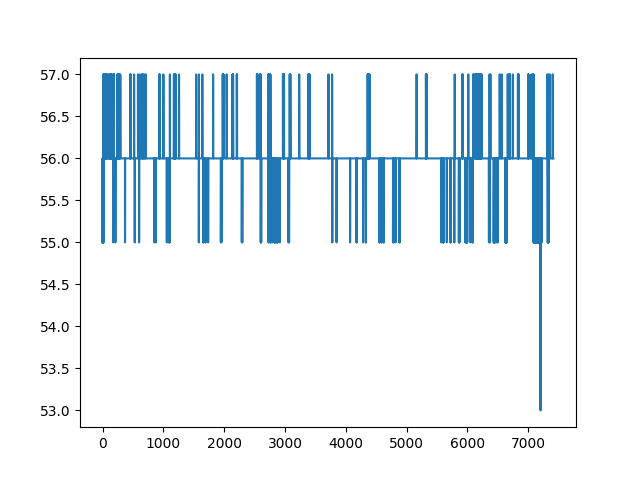

In [101]:
%matplotlib widget
fig, axes = plt.subplots(nrows=1)
axes.plot(time_data, cap_data)

In [96]:
import scipy
b, a = scipy.signal.butter(4, [8, 12], btype='bandpass', fs=fs)

In [97]:
filtered_data = scipy.signal.filtfilt(b, a, cap_data)
# for idx, sensor in enumerate(filtered_data):
    # filtered_data[idx] = [0 if np.abs(x) < 5 else x for x in sensor]

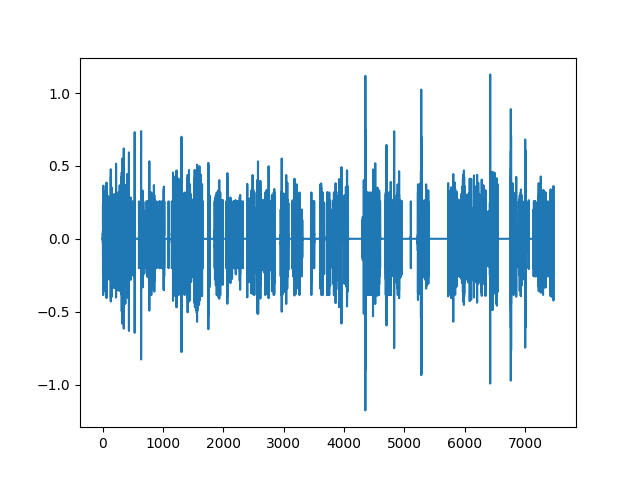

In [98]:
%matplotlib widget
fig, axes = plt.subplots(nrows=1)
axes.plot(time_data, filtered_data)

In [23]:
time_data[0,-1]

np.float64(7185.953088283539)